In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.linear_model import LogisticRegression as LRC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector as  SFS

In [2]:
from sklearn.datasets import load_wine
X, y = load_wine(return_X_y=True)

We first define a list of models and an associate list of parameters

In [3]:
# Define list of models and associate parameters
MODELS = [RFC(), 
          KNNC(), 
          Pipeline(steps=[("poly_feat", PolynomialFeatures()),
                          ("scaler", StandardScaler()),
                          ("classifier", LRC(max_iter=200))])]
PARAMS = [
    {"n_estimators": [1, 10, 50, 100]},
    {"n_neighbors": [1, 5, 10, 15, 20, 25]},
    {"classifier__C" :[1, 10, 100], "poly_feat__degree": [1, 2, 3, 4]}
]

In [4]:
err = []
for random_state in range (50):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.5, random_state=random_state)
    # Train model
    err_ = []
    for model, params in zip(MODELS, PARAMS):
        # CV
        grid = GridSearchCV(model, param_grid=params, cv= 5,
                            refit=True, n_jobs=-1) # Do the grid search in parallel
        grid.fit(X_train, y_train) # Run the grid search
        # Predict
        err_.append(grid.best_estimator_.score(X_test, y_test))
    err.append(err_)

In [5]:
err = np.asarray(err)
print(err.mean(axis=0))
print(err.std(axis=0))

[0.97146067 0.69910112 0.97191011]
[0.02146156 0.0400284  0.01962275]


In [11]:
plt.plot(err)
plt.legend(["RF","KNN", "LogisticReg"])

KNN is the worst classifier in that case, while RF and the LinearModel provides similar accuracies. Can we do better for KNN ? Maybe ... First, it is always usefull to take a look at the data:

In [7]:
df_X, df_y = load_wine(return_X_y=True, as_frame=True)
df_X.hist(figsize=(20,15))

array([[<AxesSubplot: title={'center': 'alcohol'}>,
        <AxesSubplot: title={'center': 'malic_acid'}>,
        <AxesSubplot: title={'center': 'ash'}>,
        <AxesSubplot: title={'center': 'alcalinity_of_ash'}>],
       [<AxesSubplot: title={'center': 'magnesium'}>,
        <AxesSubplot: title={'center': 'total_phenols'}>,
        <AxesSubplot: title={'center': 'flavanoids'}>,
        <AxesSubplot: title={'center': 'nonflavanoid_phenols'}>],
       [<AxesSubplot: title={'center': 'proanthocyanins'}>,
        <AxesSubplot: title={'center': 'color_intensity'}>,
        <AxesSubplot: title={'center': 'hue'}>,
        <AxesSubplot: title={'center': 'od280/od315_of_diluted_wines'}>],
       [<AxesSubplot: title={'center': 'proline'}>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

We can see that the variables "magnesium" and "proline" have a dynamic approximately 10 times higher than the other variables. In section 5.1 of the course, we will see that it might be problematic with the Euclidean distance used per default in the KNN. One solution is to scale the data to zero mean and unit variance. This is done using the StandardScaler. Let's see if it is better

In [8]:
KnnScale = Pipeline(steps=[("scaler", StandardScaler()), ("classifier", KNNC())])
params = {"classifier__n_neighbors": [1, 5, 10, 15, 20, 25]}

err_knn_scale = []
for random_state in range (50):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.5, random_state=random_state)
    # Train model
    grid = GridSearchCV(KnnScale, param_grid=params, cv= 5,
                        refit=True, n_jobs=-1) # Do the grid search in parallel
    grid.fit(X_train, y_train) # Run the grid search
    # Predict
    err_knn_scale.append(grid.best_estimator_.score(X_test, y_test))

Much better !

In [9]:
print(np.mean(err_knn_scale))

0.9480898876404492


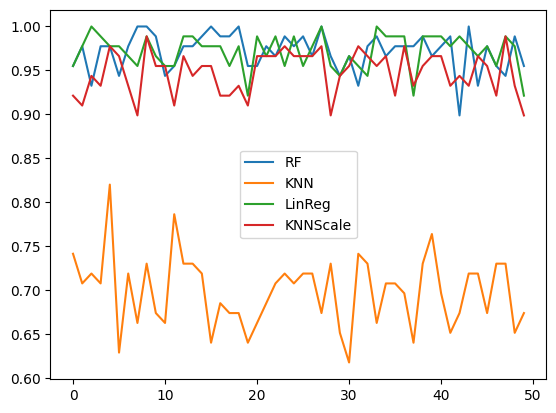

In [10]:
plt.plot(err)
plt.plot(err_knn_scale)
plt.legend(["RF","KNN", "LinReg", "KNNScale"])